

我们把按照时间次序排列的随机变量序列

$$Y_0,\, Y_1,\, Y_2, \cdots $$

称为时间序列（Time Series）。比如网站的PV、DAU，国家的GDP，股票的价格等。

这种特别的次序给模型提出了特别的挑战，包含数据内的自相关性、不可交换性、以及数据和参数的不平稳性等。

时间序列里面的内容很多，小到接下来要讲的平滑，大到金融里的混沌时间序列预测等。我准备花一些时间认真整理部分理论和应用，第一篇就分享下上手攻略，关键词是 insight。


本文采用的数据集是 Peyton Manning 的 Wikipedia 页面的 PV，下载地址是：https://github.com/facebook/prophet/tree/master/examples ，也可以在公众号后台回复 *数据集* 下载。




In [80]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import pyflux as pf
import scipy.stats as stats
import matplotlib.pyplot as plt
import reportgen as rpt
import os
import seaborn as sns
%matplotlib inline

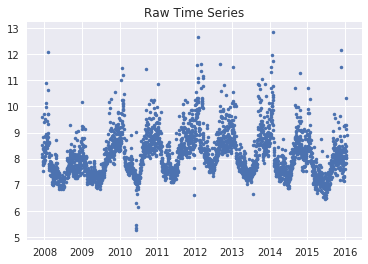

In [91]:
df = pd.read_csv('.\\data\\example_wp_peyton_manning.csv')
df['ds']=pd.to_datetime(df['ds'])
df['y']=np.log(df['y'])# tricks
fig,ax=plt.subplots()
ax.plot(df['ds'],df['y'],'.')
ax.set_title('Raw Time Series')
fig.savefig('.\\_images\\原图.png',dpi=500)

## 1.  手动平滑时间序列和获取趋势项

假设时间序列有周期为 s 的周期性趋势，一种最简单的平滑方式就是移动平均法(moving average)，假设窗口设为7，则 

$$s_t=\frac{1}{7}(y_t+y_{t-1}+y_{t-2}+\cdots +y_{t-6})$$

其实就是股票中的5日均线、20日均线。

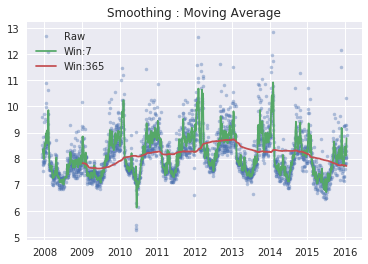

In [82]:
y1=pd.rolling_mean(df['y'],window=7)
# 如果要使得平滑后长度一致，可以设置参数,min_periods=1
y2=pd.rolling_mean(df['y'],window=365)
fig,ax=plt.subplots()
ax.plot(df['ds'],df['y'],'.',alpha=0.4,label='Raw')
ax.plot(df['ds'],y1,'-',label='Win:7')
ax.plot(df['ds'],y2,'-',label='Win:365')
ax.legend()
ax.set_title('Smoothing : Moving Average')
fig.savefig('.\\_images\\smoothing_moving_average.png',dpi=500)

移动平均法只利用了前面n天的数据，而且权重一样。一种更好的方法是指数平滑法（exponentially weighted moving average），越靠近当天的数据权重越高

$$s_0=y_0,  \,\, s_t=\alpha y_t +(1-\alpha)y_{t-1}$$

从这个公式看不出指数在哪，但当我们把它展开后就很明显了。

$$s_t=\alpha [y_t+(1-\alpha)y_{t-1} + \cdots + (1-\alpha)^{t-1}y_1] + (1-\alpha)^{t} y_0$$

事实上 EMWA 是一种没有常数项的ARIMA(0,1,1)模型，当把alpha的选取标准设为最小化 s_t 和 y_{t+1} 就是一个很简单的时间序列预测模型。

股票中的MACD指标利用的就是指数平滑，其中的DIF线就是12日的指数平滑值 减去26日的指数平滑值。 

In [83]:
?pd.ewma(df['y'],window=30)

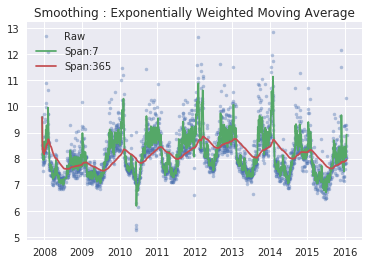

In [84]:
y1=pd.ewma(df['y'],span=7)
y2=pd.ewma(df['y'],span=365)
fig,ax=plt.subplots()
ax.plot(df['ds'],df['y'],'.',alpha=0.4,label='Raw')
ax.plot(df['ds'],y1,'-',label='Span:7')
ax.plot(df['ds'],y2,'-',label='Span:365')
ax.legend()
ax.set_title('Smoothing : Exponentially Weighted Moving Average')
fig.savefig('.\\_images\\smoothing_exponentially_weighted_moving_average.png',dpi=500)

除此之外还有一些更好的方法，大家可以试试，比如 Holt-Winter三次指数平滑法等

## 2. 利用 Prophet 看趋势和周期

时间序列经过合理的函数变换后都可以被认为是由三个部分叠加而成。分别是趋势项部分、周期项部分和噪声项部分

$$y(t) = g(t) +s(t) +\varepsilon_t$$

其中 s(t) 表示周期项，如 weekly seasonality（周一和周二是不一样的）和 yearly seasonality（平时和寒暑假是不一样的等）等。对于一些特别的场景，比如网站的DAU，还需要考虑节假日成分、特殊时间成分等。

我们可以利用 Facebook 开源的包 Prophet 来分解。

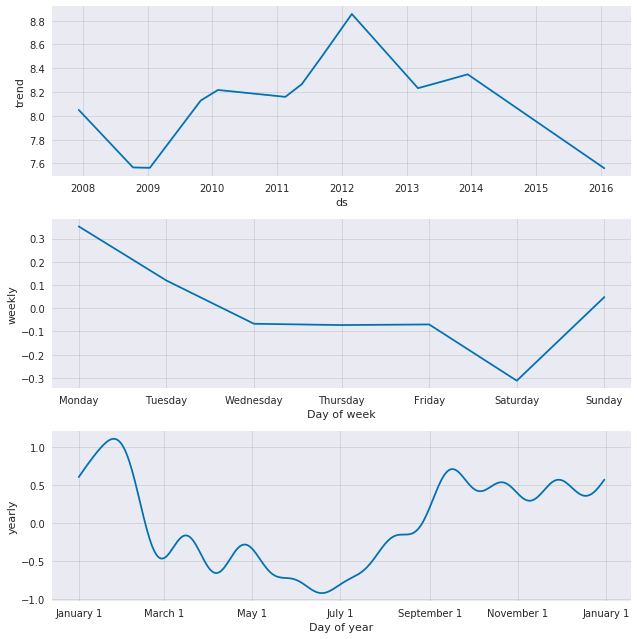

In [85]:
# 可以添加节假日参数，这样分解会更准确
m=Prophet()
m.fit(df)
future=m.make_future_dataframe(periods=1)
forecast=m.predict(future)
forecast1=forecast.loc[:,['ds','yhat']]
#m.plot(forecast);# 蓝色线是预测值
fig=m.plot_components(forecast,weekly_start=1)
fig.savefig('.\\_images\\components_timeseries.png',dpi=500)

Prophet 利用加法模型把序列分成了4个部分（如果给定节假日参数，则是5个部分）。我们可以大概看下它的预测效果，之后我准备花一篇文章专门梳理各个方法（包）的预测效果。

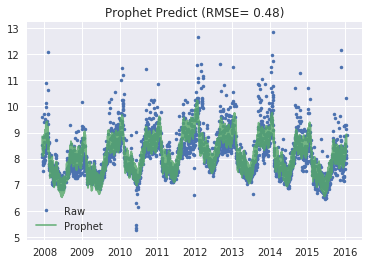

In [86]:
df1=pd.merge(forecast.loc[:,['ds','yhat']],df,on='ds',how='inner')
# 计算RMSE
from sklearn import metrics
rmse=np.sqrt(metrics.mean_squared_error(df1['yhat'],df1['y']))
fig,ax=plt.subplots()
ax.plot(df1['ds'],df1['y'],'.',label='Raw')
ax.plot(df1['ds'],df1['yhat'],'-',alpha=0.8,label='Prophet')
ax.legend()
ax.set_title('Prophet Predict (RMSE= {:.2f})'.format(rmse));
fig.savefig('.\\_images\\prophet_predict.png',dpi=500)

PS： 因为我们用的是训练集，所以这个RMSE并不能用来评估预测的效果。

In [87]:
#from pyramid.arima import auto_arima
#stepwise_fit = auto_arima(wineind, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
#                          start_P=0, seasonal=True, d=1, D=1, trace=True,
#                          error_action='ignore',  # don't want to know if an order does not work
#                          suppress_warnings=True,  # don't want convergence warnings
#                          stepwise=True)  # set to stepwise

## 3. 从频域看可能存在的周期

我们还可以利用Fourier Transform 在频域里看看时间序列。给定一个函数 f(x), 则其 傅里叶变换可以表示为：

$$\hat{f}(x)=\int f(x)e^{-2\pi i x \xi} dx$$

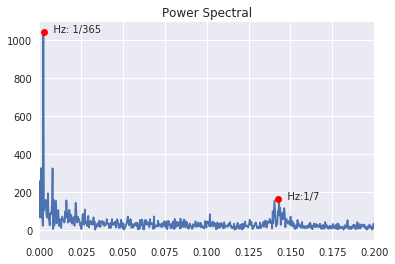

In [88]:
w = np.fft.fft(df['y']-y4)
n=len(w)
w=w[1:]
power = np.abs(w[:int(n/2)])
nyquist = 1/2
freq = np.arange(int(n/2))/(n/2)*nyquist
fig,ax=plt.subplots()
ax.plot(freq,power)
ax.set_xlim(0,0.2)
ax.set_title('Power Spectral');
ax.plot(1/365,power[7],'o',color='red')
ax.text(1/365,power[7],'   Hz: 1/365')
ax.plot(1/7,power[416],'o',color='red')
ax.text(1/7,power[416],'   Hz:1/7')
fig.savefig('.\\_images\\power_spectral.png',dpi=500)

这个图看起来比较麻烦，我们把横轴转换成周期

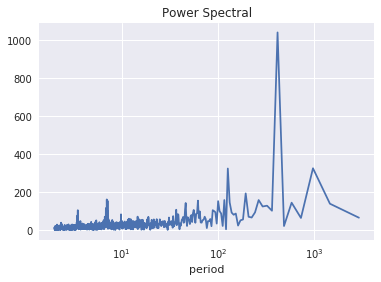

In [89]:
period=1/freq
fig,ax=plt.subplots()
ax.semilogx(period,power)
ax.set_title('Power Spectral');
ax.set_xlabel('period')
fig.savefig('.\\_images\\power_spectral_period.png',dpi=500)

## 4.  从时频域看异常值


小波变换可以把时间序列直接在时频域进行分解成高频部分和低频部分。低频部分包含了序列的大部分信息，高频部分则包含了一些细节信息。现在的JPEG2000压缩标准就是基于小波变换设计的，如果将一张图片进行小波变换，则低频部分跟原图差别很小，高频部分则大概能看出图片的轮廊，通过一些方法就能进行图片边界的检测了，大家有兴趣可以试试。


首先回顾一下小波变换的相关理论. 详细的我就不讲了，比较复杂。设 $f(x)\in L^2(\mathbb{R})$，对于任意精度 $\varepsilon$，我们都能找到一个 $j$ 使得

$$ \| f-f_j\|_{L^2} \leq \varepsilon,\quad  f_j \in V_j, $$


$$ f_j(x)=\sum_{k\in \mathbb{Z}}c_{j,k}\varphi_{j,k}(x) $$

其中 $\{\varphi_{j,k}(x)\}$ 是具有紧支撑的函数族，比如 db1,db2,...

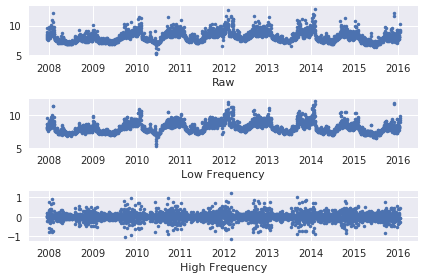

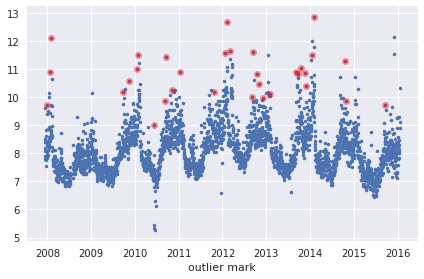

In [90]:
import pywt
(cA,cD)=pywt.dwt(df['y'],'db4')
n=len(df)
cAn=pywt.upcoef('a',cA,'db4',take=n)
cDn=pywt.upcoef('d',cD,'db4',take=n)
fig,[ax0,ax1,ax2]=plt.subplots(3,1)
ax0.plot(df['ds'],df['y'],'.')
ax0.set_xlabel('Raw')

ax1.plot(df['ds'],cAn,'.')
ax1.set_xlabel('Low Frequency')

ax2.plot(df['ds'],cDn,'.')
ax2.set_xlabel('High Frequency')

fig.tight_layout()
fig.savefig('.\\_images\\小波分解.png',dpi=500)

fig,ax=plt.subplots()
cDn[np.abs(cDn)<3*np.std(cDn)]=0
ax.plot(df['ds'],df['y'],'.')
tmp=df.copy()
tmp['cDn']=cDn
tmp=tmp.loc[tmp['cDn']>0,['ds','y']]
ax.plot(tmp['ds'],tmp['y'],'o',alpha=0.4,color='red')
ax.set_xlabel('outlier mark')
fig.tight_layout()
fig.savefig('.\\_images\\异常值标记.png',dpi=500)

接下来的计划还没想好，大概率有一篇讲ARIMA系列模型，一篇评估现有各种包的预测效果，一篇讲 Change Point ，一篇将 RNN 和 LSTM。


## 参考文献

[1]. 指数平滑法, http://connor-johnson.com/2014/02/01/smoothing-with-exponentially-weighted-moving-averages/

[2]. 指数平滑法, https://www.jianshu.com/p/6fb0408b3f54